In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.9.post3: Fast Llama patching. Transformers = 4.45.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",

    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.9.post3 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
#template hazirla
counseling_prompt = """
### Counseling Conversation:
[CONTEXT]: {context}
[RESPONSE]: {response}
### End of conversation
"""


EOS_TOKEN = tokenizer.eos_token


def format_counseling_data(examples):
    contexts = examples['Context']
    responses = examples['Response']
    texts = []
    for context, response in zip(contexts, responses):
        text = counseling_prompt.format(context=context, response=response) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}


from datasets import load_dataset
dataset = load_dataset("Amod/mental_health_counseling_conversations", split="train")


formatted_dataset = dataset.map(format_counseling_data, batched=True)


print(formatted_dataset.column_names)


['Context', 'Response', 'text']


In [ ]:
# Check the column names of the dataset
print(dataset.column_names)


['Context', 'Response']


In [ ]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=formatted_dataset,  # Use the newly formatted dataset
    dataset_text_field="text",  # Specify that 'text' contains the formatted data
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=60,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
    ),
)


Map (num_proc=2):   0%|          | 0/3512 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.984 GB of memory reserved.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,512 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.961200
2,2.550400
3,2.855400
4,2.794100
5,2.594300
6,2.603400
7,2.375600
8,2.453900
9,2.494900
10,2.376800


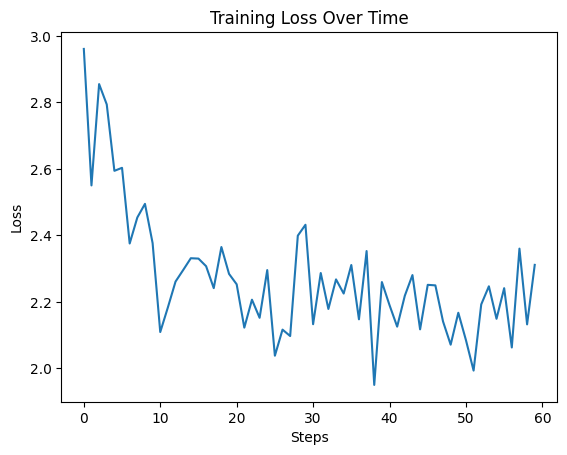

In [ ]:
#@title Train
from transformers import TrainerCallback

class LossRecorder(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs.get("loss", None) is not None:
            self.losses.append(logs["loss"])


loss_recorder = LossRecorder()
trainer.add_callback(loss_recorder)

trainer_stats = trainer.train()

import matplotlib.pyplot as plt

plt.plot(loss_recorder.losses)
plt.title('Training Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.savefig('training_loss_curve.png')
plt.show()


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

642.8567 seconds used for training.
10.71 minutes used for training.
Peak reserved memory = 8.713 GB.
Peak reserved memory for training = 2.729 GB.
Peak reserved memory % of max memory = 59.079 %.
Peak reserved memory for training % of max memory = 18.504 %.


In [ ]:
#@title Cikarim

In [ ]:
# counseling_prompt tanımlanır
counseling_prompt = """
### Question:
{}

### Answer:
{}
"""

FastLanguageModel.for_inference(model)

input_text = counseling_prompt.format(
    "My grandson's step-mother sends him to school with a pink Barbie backpack as a form of punishment.",  # Sorgu
    ""  # Yanıt - Burası boş bırakılır çünkü modelin yanıt üretmesi beklenir
)

inputs = tokenizer([input_text], return_tensors="pt").to("cuda")


from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
outputs = model.generate(**inputs, streamer=text_streamer, max_new_tokens=250)


generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)


<|begin_of_text|>
### Question:
My grandson's step-mother sends him to school with a pink Barbie backpack as a form of punishment.

### Answer:

I would suggest that you talk to your grandson about what he is feeling and how he is feeling.  He may not be able to articulate his feelings but he may be able to tell you that he doesn't like it.  I would also suggest that you speak with his mother about this.  It is not a healthy way to discipline a child.  This could be a sign of deeper issues in the relationship between your grandson and his stepmother.  You may want to consider having a family therapy session to address the issues in the relationship between your grandson and his stepmother.  It may also be helpful to discuss how to discipline your grandson with his mother.  There are many other ways to discipline a child that do not involve humiliation and embarrassment.  There are also many other ways to discipline a child that do not involve involving other people in the discipline.  

In [ ]:
#@title  Test

In [ ]:

print(f"Training completed. Final training loss: {trainer_stats.metrics['train_loss']}")
print(f"Evaluation metrics: {trainer_stats.metrics}")
print(f"loss curve ")


Training completed. Final training loss: 2.2762949109077453
Evaluation metrics: {'train_runtime': 642.8567, 'train_samples_per_second': 0.747, 'train_steps_per_second': 0.093, 'total_flos': 7937795459481600.0, 'train_loss': 2.2762949109077453, 'epoch': 0.1366742596810934}
loss curve 


In [ ]:
import math
perplexity = math.exp(trainer_stats.metrics['train_loss'])
print(f"Model Perplexity: {perplexity}")


Model Perplexity: 9.740523960379797


In [ ]:
with open("test_results.txt", "w") as f:
    f.write(f"Training loss: {trainer_stats.metrics['train_loss']}\n")
    f.write(f"Evaluation metrics: {trainer_stats.metrics}\n")
    f.write(f"Model Perplexity: {perplexity}\n")
